# Notas



Pipeline sugerido: <br>
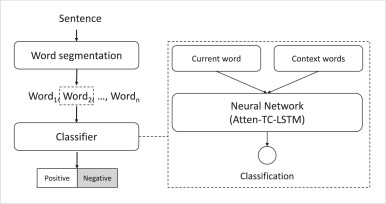

Fuente: https://reader.elsevier.com/reader/sd/pii/S092523121931687X?token=FC73D0A2D97F651107829FA32607FEB1805FAEC2511A5EE011CEBD5C1E56D90AD074665F19F578230F696CD46DB25CA2&originRegion=eu-west-1&originCreation=20230307084138

In [82]:
!pip install matplotlib

In [83]:
import os.path
import requests
from shutil import unpack_archive

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

# Preprocesamiento muy inicial de los datos

In [84]:
# datos preparados
url_datos_moodle = "https://gist.githubusercontent.com/w-dan/b84bdbfbd86b610a89aa0aa57e6efb5e/raw/aeaffaa9d26c66678b697ecb9fd99fd0c8eaca52/papers.csv"

In [85]:
df = pd.read_csv(url_datos_moodle)
df

,id,title,abstract,Unnamed: 3,keywords,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1,Ensemble Statistical and Heuristic Models for ...,Statistical word alignment models need large a...,NaN,"statistical word alignment, ensemble learning,...",NaN,NaN,NaN
1,2,Improving Spectral Learning by Using Multiple ...,Spectral learning algorithms learn an unknown ...,NaN,"representation, spectral learning, discrete fo...",NaN,NaN,NaN
2,3,Applying Swarm Ensemble Clustering Technique f...,Number of defects remaining in a system provid...,NaN,"software defect prediction, particle swarm opt...",NaN,NaN,NaN
3,4,Reducing the Effects of Detrimental Instances,Not all instances in a data set are equally be...,NaN,"filtering, label noise, instance weighting",NaN,NaN,NaN
4,5,Concept Drift Awareness in Twitter Streams,Learning in non-stationary environments is not...,NaN,"twitter, adaptation models, time-frequency ana...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
443,444,A Machine Learning Tool for Supporting Advance...,"In the current era of big data, high volumes o...",NaN,"machine-learning,unsupervised-learning,knowled...",NaN,NaN,NaN
444,445,Advanced ECHMM-Based Machine Learning Tools fo...,We present a novel approach for accurate chara...,NaN,"workload characterization,hmm,cepstral coeffic...",NaN,NaN,NaN
445,446,A Cluster Analysis of Challenging Behaviors in...,"We apply cluster analysis to a sample of 2,116...",NaN,"cluster analysis,autism spectrum disorder,chal...",NaN,NaN,NaN
446,447,Predicting Psychosis Using the Experience Samp...,Smart phones have become ubiquitous in the rec...,NaN,"predicting psychosis,esm,mhealth,svm,gaussian ...",NaN,NaN,NaN


Separación de variable objetivo y demás atributos

In [86]:
y = df['keywords']
X = df.drop(['keywords'], axis=1)

Comprobamos las columnas Unnamed, tienen muchos valores NaN y parecen raras

In [87]:
print("El dataset tiene ", len(df), " filas")

print("===== NULOS =====")
df.isnull().sum()

El dataset tiene  448  filas
===== NULOS =====


id              0
title           0
abstract        0
Unnamed: 3    448
keywords        0
Unnamed: 5    443
Unnamed: 6    444
Unnamed: 7    447
dtype: int64

In [88]:
X = X.drop(['id', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'], axis=1)
X

,title,abstract
0,Ensemble Statistical and Heuristic Models for ...,Statistical word alignment models need large a...
1,Improving Spectral Learning by Using Multiple ...,Spectral learning algorithms learn an unknown ...
2,Applying Swarm Ensemble Clustering Technique f...,Number of defects remaining in a system provid...
3,Reducing the Effects of Detrimental Instances,Not all instances in a data set are equally be...
4,Concept Drift Awareness in Twitter Streams,Learning in non-stationary environments is not...
...,...,...
443,A Machine Learning Tool for Supporting Advance...,"In the current era of big data, high volumes o..."
444,Advanced ECHMM-Based Machine Learning Tools fo...,We present a novel approach for accurate chara...
445,A Cluster Analysis of Challenging Behaviors in...,"We apply cluster analysis to a sample of 2,116..."
446,Predicting Psychosis Using the Experience Samp...,Smart phones have become ubiquitous in the rec...


In [89]:
y = pd.DataFrame(y, columns=['keywords'])
y

,keywords
0,"statistical word alignment, ensemble learning,..."
1,"representation, spectral learning, discrete fo..."
2,"software defect prediction, particle swarm opt..."
3,"filtering, label noise, instance weighting"
4,"twitter, adaptation models, time-frequency ana..."
...,...
443,"machine-learning,unsupervised-learning,knowled..."
444,"workload characterization,hmm,cepstral coeffic..."
445,"cluster analysis,autism spectrum disorder,chal..."
446,"predicting psychosis,esm,mhealth,svm,gaussian ..."


Hacer un bag of words con estos abstracts produciría una segmentación demencial que nos haría perder el hilo, aunque aún es pronto para descartarlo. Podemos emplear alguna técnica de [word embedding](https://es.wikipedia.org/wiki/Word_embedding):

# Entrenamiento de word embedding con GLoVe

Vamos a entrenar una capa de word embedding con el conjunto de datos de Stanford:

In [90]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (16, 9),'figure.dpi': 100})

tf.compat.v1.disable_eager_execution()  # Esto es por un problema (creo) con las RTX2070

In [91]:
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = 'glove.6B.zip'
GLOVE_DIR = 'glove'

if not os.path.isdir(GLOVE_DIR):
    # Descargamos el dataset comprimido de GloVe (si no lo tenemos ya)
    if not os.path.exists(GLOVE_FILE):
        with open(GLOVE_FILE, 'wb') as f:
            r = requests.get(GLOVE_URL, allow_redirects=True)
            f.write(r.content)
    # Lo descomprimimos en el directorio 'glove'
    unpack_archive(GLOVE_FILE, 'glove/')

Establecemos parámetros

In [100]:
lens = [len(s) for s in X['abstract']]

lens = pd.DataFrame(lens)


Establecemos MAX_SEQUENCE_LENGTH a la mediana de las longitudes de los abstracts, de aproximadamente 986 palabras.

In [102]:
# Dimensiones de los word vectors (50, 100, 200 o 300)
EMBEDDING_DIM = 50
# Tamaño máximo de nuestro vocabulario (se escogerán las más frecuentes)
MAX_VOCAB_SIZE = 10000
# El tamaño de la frase más larga con la que alimentar el modelo
MAX_SEQUENCE_LENGTH = int(lens.median())

In [94]:
del lens

We load the Embedding of the dimension specified in the configuration

In [95]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt')) as f:
    for line in f:
        values = line.split()
        word2vec[values[0]] = np.asarray(values[1:], dtype='float32')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 50-d embedding... done (400000 word vectors loaded)


In [96]:
print('Loading training articles dataset... ', end='')

targets = y.values[:,0]
abstracts = X.values[:,1]
titles = X.values[:,0]

print(f'done ({len(y)} abstracts loaded)')
print(f'Biggest abstract length:  {max(len(s) for s in abstracts)}')
print(f'Smallest abstract length: {min(len(s) for s in abstracts)}')
print(f'Avg. abstract length:     {np.mean([len(s) for s in abstracts])}')
# print(f'Median abstract length:   {sorted(len(s) for s in X)[len(X) // 2]}')
print('-' * 20)
print(f'Example abstract: {X.iloc[9]}')
print(f'Example keywords: {targets[9]}')

Loading training articles dataset... done (448 abstracts loaded)
Biggest abstract length:  2008
Smallest abstract length: 10
Avg. abstract length:     1038.9441964285713
--------------------
Example abstract: title       Detection of abnormal human behavior using a m...
abstract    Automatic detection of abnormal events is one ...
Name: 9, dtype: object
Example keywords: abnormal event detection, low-rank approximation, adaptive learning


In [138]:
len(titles[133].split(' '))

14

In [107]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(titles)
sequences = tokenizer.texts_to_sequences(titles)
word_index = tokenizer.word_index

print(f'Biggest index: {max(max(seq) for seq in sequences if len(seq) > 0)}')
print(f'Unique tokens: {len(word_index)}')
print('-' * 20)
print(f'Example comment: {abstracts[0]}: {sequences[1]}')

Biggest index: 1616
Unique tokens: 1616
--------------------
Example comment: Statistical word alignment models need large amount of training data while they are weak in small-size corpora. This paper proposes a new approach of unsupervised hybrid word alignment technique using ensemble learning method. This algorithm uses three base alignment models in several rounds to generate alignments. The ensemble algorithm uses a weighed scheme for resampling training data and a voting score to consider aggregated alignments. The underlying alignment algorithms used in this study include IBM Model 1, 2 and a heuristic method based on Dice measurement. Our experimental results show that by this approach, the alignment error rate could be improved by at least %15 for the base alignment models.: [67, 328, 3, 33, 4, 93, 154]


In [139]:
data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    value=0,
    maxlen=MAX_SEQUENCE_LENGTH
)
print(f'Data tensor shape: {data.shape}')
print(len(data))
data[121]

Data tensor shape: (448, 985)
448


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   